# 04: Deutsch's Algorithm

Deutsch's algorithm from 1985 is the first and simplest quantum algorithm. Its significance lies in the fact that it solves a specific problem, *Deutsch's problem*, faster than any classical algorithm.
   
**The Deutsch's problem:** Consider a function $f : \{0,1\} \rightarrow \{0,1\}$ (a function that can take $0$ or $1$ as an input and returns $0$ or $1$ as an output). Is it true that $f(0)=f(1)$?


Any classical algorithm would have to evaluate the function $f(x)$ twice, once with $x=0$ and once with $x=1$, to see if the results coincide or not. By using *superposition* and *interference*, quantum computing allows us to solve the problem with a single evaluation. 

Deutsch's algorithm is executed as a simple quantum circuit with two qubits. In brief, the idea is to evaluate the given problem function $f(x)$ using a superposition of $0$ and $1$ as an input. With the help of an auxiliary qubit, whose state is interfered with the input qubit, a single execution of Deutsch's algorithm reveals whether the studied function is **constant** or **varied**

### The 'oracle' function $f(x)$

In the lingo of computer science, black box functions that give some output for a given input, but whose internal details are not relevant or known, are called *oracles*. The aim of Deutsch's algorithm is to solve whether a given oracle function is **constant** or **varied**.

- **Constant function:** $f(0)=f(1)$ 

- **Varied (NOT-function):** $f(0) \neq f(1)$ 

### The quantum oracle $U_f$ 

To make a quantum version of the oracle function, we have to represent it as a quantum gate. Since all quantum gates have to be **reversible** (no information can be lost), we need two qubits to realize a one-bit oracle function $f(x)$.

The quantum oracle gate $U_f$ operates on a arbitraty two-qubit state as: $U_f|\hspace{0.1cm}x~ y\hspace{-0.1cm}> = |\hspace{0.1cm}x~ y \oplus f(x) >$, where $\oplus$ means *addition modulo two*. The four possible input combinations are:
1) $\quad 0 \oplus 0=0$
2) $\quad 0 \oplus 1=1$
3) $\quad 1 \oplus 0=1$
4) $\quad 1 \oplus 1=0$

As a first step of demonstrating the Deutsch algorithm on Qiskit, we prepare an 'unknown' quantum oracle $U_f$, that realizes the oracle function $f(x)$ in a reversible way. We want to choose our oracle gate randomly (**so that we don't know what it exactly is**). In this notebook, we will use Deutsch's algorithm to see whether our oracle function $f(x)$ is:

- **Constant f(x):** $U_f$ is identity operator (no gate) or X-gate

- **Varied f(x):** $U_f$ is CNOT-gate or NOT-CNOT-gate


## Oracle: Implementation

First we implement out quantum oracle

In this implementation, we only need basic qiskit and Python packages. We start by importing those.

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from iqm.qiskit_iqm import IQMProvider

from numpy.random import randint    # For generating random integer
import matplotlib.pyplot as plt
import os

Next, we randomly 'hide' one of the two gates behind the quantum oracle's name $U_f$.

Below, we implement the oracle by creating a quantum circuit and allocating two qubits, $q_0$ and $q_1$.

We then utilize a random number generator to add one of two possible operations representing function $f(x)$. 

The **constant function** is implemented with identity operation, in which case we don't add any gates, or X-gate. This means that the qubit $q_0$ will be same as its initial value.

The **varied function** is implemented with by either the CNOT gate or NOT-CNOT gate. Phase kickback will cause the qubit $q_0$ being flipped.

**Your task in below cell is to add gates to the oracle circuit. Keep in mind that the 2nd qubit is your target qubit**

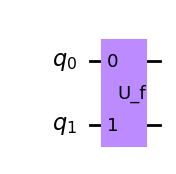

In [2]:
## We use numpy random integrer generator to choose which gate we will append
random_integer = randint(4)

if random_integer == 1:
    oracle = QuantumCircuit(2)
    
elif random_integer == 2:
    oracle = QuantumCircuit(2)
    oracle.x(1)

elif random_integer == 3:
    oracle = QuantumCircuit(2)
    oracle.cx(0,1)
else:
    oracle = QuantumCircuit(2)
    oracle.x(0)
    oracle.cx(0,1)
    oracle.x(0)

# We can convert the circuit to custom gate
oracle = oracle.to_gate(label = 'U_f')

# In qiskit you cant draw gates
# We can visualize the oracle gate by appending it on circuit
oracle_visualized = QuantumCircuit(2)
oracle_visualized.append(oracle, range(2))
oracle_visualized.draw('mpl', style="clifford")

We now have a quantum oracle that is **randomly** set to be either the Identity gate or X-gate (constant $f(x)$), or the CNOT or NOT-CNOT (varied $f(x)$). Our task is to solve, **with just a single evaluation**, which one it is. We do this by building smart quantum machinery around the oracle gate.

**Note:** The Deutch algorithm is just a demonstration of quantum computers solving black box problems faster than classical computers. In reality, the algorithm provides no practical quantum advantage, since we add the gates to the circuit, and thus already kinda know what $U_f$ is before even running the algorithm.

# Deutsch's algorithm: Implementation

With the mystery oracle gate prepared above, we can now build a quantum circuit that executes Deutsch's algorithm and determines in one evaluation whether the oracle is constant $(f(0)=f(1))$ or variable $(f(0)\neq f(1))$ with 100% accuracy. The outline of Deutsch's algorithm is given below.

+ **Inputs:** A black box $U_f$ which performs the tranformation $| x\rangle| y\rangle \rightarrow | x\rangle | y \oplus f(x)\rangle$, for $x \in \{ 0,1 \}$ and $f(x) \in \{ 0,1 \}$. The function $f(x)$ must be either *constant* i.e. its output does not depend on the input $x$ or *varied* i.e the output depends on $x$

+ **Outputs:** 0 if $f(x)$ is constant and 1 if $f(x)$ is varied

+ **Runtime:** One evaluation of $U_f$. Always succeeds.

+ **Procedure:**
\begin{alignat*}{2}
 &1. \quad |0\rangle |1\rangle \qquad && \text{initialize the state} \\
 &2. \quad \rightarrow \bigg[ \frac{|0\rangle + |1\rangle}{\sqrt{2}} \bigg] \bigg[ \frac{|0\rangle - |1\rangle}{\sqrt{2}} \bigg] \qquad && \text{create superposition using Hadamard gates} \\
 &3. \quad \rightarrow \bigg[ \frac{(-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle}{\sqrt{2}} \bigg] \bigg[ \frac{|0\rangle - |1\rangle}{\sqrt{2}} \bigg] \qquad && \text{calculate } f \text{ using } U_f  \\
 &4. \quad \rightarrow (-1)^{f(0)} \bigg[ \frac{(1+(-1)^{f(0) \oplus f(1)} )|0\rangle + (1-(-1)^{f(0) \oplus f(1)})|1\rangle }{2} \bigg] \bigg[ \frac{|0\rangle - |1\rangle}{\sqrt{2}} \bigg] \qquad && \text{use Hadamard gate on 1st qubit} \\
 &5. \quad \rightarrow 0 \text{ or } 1 \qquad && \text{measure 1st qubit to deduce the answer} \\
\end{alignat*}

Let's build and evaluate the circuit performing Deutsch's algorithm in Qiskit

**Your task in below cell is to build circuit for the Deutch algorithm by following the instructions**

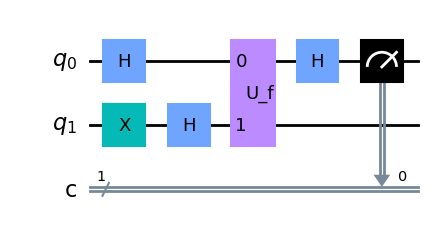

In [3]:
# Allocate two qubits and one classical biy
qc = QuantumCircuit(2,1)

qc.x(1) # flip 2nd qubit
qc.h(0) # put 1st qubit into superposition
qc.h(1) # put 2nd qubit into superposition (with opposite phase)

qc.append(oracle, [0,1]) # Apply our randomly selected oracle

# apply Hadamard gate again to 1st qubit. This will undo the superposition
# and reduce 1st qubit to state |0> if the oracle was constant or to state |1> if it was varied
qc.h(0)

# We want to determine the oracle by measuring the 1st qubit
qc.measure(0,0) 

 ## Visualize the circuit
qc.decompose(reps=0).draw('mpl', style="clifford")

By running the circuit and measuring the 1st qubit, we now should be able to figure out the oracle $U_f$ from only one measurement

+ Measured qubit $|0\rangle \rightarrow U_f$ is identity or X-gate; $f(x)$ is constant
+ Measured qubit $|1\rangle \rightarrow U_f$ is CNOT or NOT-CNOT; $f(x)$ is varied

The algorithm only works with one measurement when using an ideal noiseless simulator. In the cell below, we run the circuit using `Aer` simulator

In [4]:
# Retrieve backend for ideal qiskit Aer simulator
backend_simulator = Aer.get_backend('statevector_simulator')

# Our circuit contains unknown instruction, which is the oracle we named U_f
# Transpiling circuit tells the simulator how to run it
qc_transpiled = transpile(qc, backend_simulator)

# The goal was to run circuit once, so we set shots=1
result_1 = backend_simulator.run(qc_transpiled, shots=1).result()
counts_1 = result_1.get_counts()

# We get the measured qubit from the only key in dictionary
measured_qubit = list(counts_1.keys())[0]

# print the state of the first (and only) sample in results
print(f"Measured qubit: |{measured_qubit}>")
if (measured_qubit=='0'):
    print(f"Oracle was identity or X-gate -> f(x) is constant")
else:
    print(f"Oracle was CNOT or NOT-CNOT -> f(x) is varied")


Measured qubit: |1>
Oracle was CNOT or NOT-CNOT -> f(x) is varied


Determining the unknown oracle took just a single measurement.

Let us convince ourselves, by running the algorithm many times, that this ideal simulation (no noise errors) indeed always succeeds.  

In [5]:
result_2 = backend_simulator.run(qc_transpiled, shots=100).result()
counts_2 = result_2.get_counts()
print(f"Measurements: {counts_2}")

Measurements: {'1': 100}


The result is indeed the same for every shot. Let's print the statevector to see what of the qubit state is before we measure it. We are looking at the 1st qubit, which should always have the same state regardless of the state of the 2nd qubit.

**Note:** The order of qubits displayed in the statevector is $|q_N...q_2q_1q_0 \rangle$, so it is to be read from right to left to match the qubit indices in the circuit

In [6]:
state_2 = result_2.get_statevector()
display(state_2.draw(output='latex'))

<IPython.core.display.Latex object>

Finally, we can print the transpiled circuit. We can see that if the qubit was measured in state $|1\rangle$, the circuit contains 2-qubit gate. Otherwise, there are no 2-qubit gates.

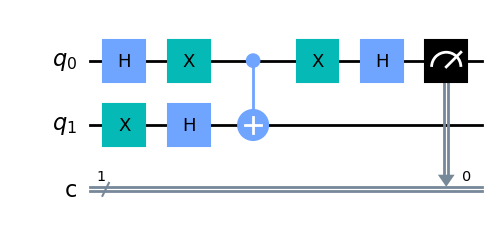

In [7]:
qc_transpiled.decompose(reps=0).draw('mpl', style="clifford")

## Deutch Algorithm on Helmi

As we saw, the Deutch algorithm is deterministic algorithm. This means it works well on ideal noiseless simulator, but is unreliable when run with single shot on real QPU.

**Your task is now to run the Deutch algorithm on Helmi to see what happens**

In [8]:
## Helmi Quantum Computer------------------------------
HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')
provider = IQMProvider(HELMI_CORTEX_URL)
backend_helmi = provider.get_backend()
##-----------------------------------------------------

## Helmi Simulator (BACKUP OPTION)-------------------------------------
#from iqm.qiskit_iqm import IQMFakeAdonis
#backend_helmi = IQMFakeAdonis()
##-----------------------------------------------------

qc_transpiled_helmi = transpile(qc, backend_helmi)

# The goal was to run circuit once, so we set shots=1
result_3 = backend_helmi.run(qc_transpiled_helmi, shots=100).result()
counts_3 = result_3.get_counts()

print(f"Measurements: {counts_3}")


Measurements: {'1': 98, '0': 2}


Do you think the algorithm would work with just a single shot?

## Deutsch-Josza algorithm

There is a generalization of the Deutsch algorithm from 1992, known as *Deutsch-Josza algorithm*, that operates on any number of qubits. It is really similar to the Deutsch algorithm, the difference being that the input is now a string of n bits (instead of 1 bit) and the algorithm uses $n+1$ qubits instead of 2.

The Deutsch-Josza algorithm works only on the condition that the oracle function is either constant (0 on all outputs or 1 on all outputs) or balanced (returns 1 for half of the input strings and 0 for the other half). For such oracle functions, the Deutsch-Josza algorithm figures out whether the oracle is balanced or constant with a single evaluation regardless of the number of bits in the input string.

A deterministic classical algorithm would take in the worst case $2^{\text{n}-1}+1$ evaluations of the oracle function to solve the same problem, where $n$ is a number of bits.

## Takeaway

The outcome of Deutcsh's algorithm reveals whether the oracle function, $f(x)$, under study, is constant or variable. Based on the logic of the algorithm, the outcome implies the following:
+ Qubit measured in state $|0\rangle$ implies $f(0)=f(1)$; the oracle is constant
+ Qubit measured in state $|1\rangle$ implies $f(0)\neq f(1)$; the oracle is variable

On the noiseless quantum computer (simulator in this case), the algorithm succeeds with 100% probability and a single evaluation of the oracle function, which is impossible for classical computers. 